In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
sale_data = pd.read_csv('./m5-forecasting-accuracy/sales_train_validation.csv')
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

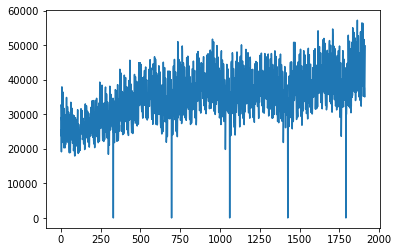

In [19]:
plt.plot(total_sum)

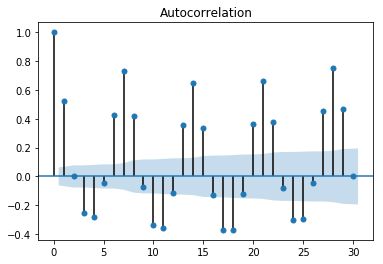

In [30]:
# 自相关性
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(total_sum[-1000:]);

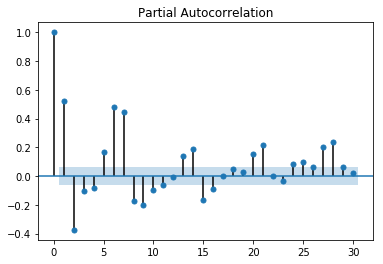

In [29]:
# 偏自相关性
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(total_sum[-1000:]);

In [68]:
# 单位根检验
from statsmodels.stats.diagnostic import unitroot_adf
print('P_value:{}'.format(unitroot_adf(total_sum[-200:])[1]))

P_value:0.1753988166862852


In [69]:
# 做差分
# 再做单位根检验
print('P_value:{}'.format(unitroot_adf(np.diff(total_sum[-200:]))[1]))

P_value:1.7133196516519583e-05


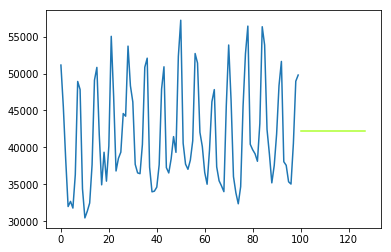

In [46]:
# 均值预测
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-28:].sum()/len(total_sum[-28:])]*28,color='greenyellow')

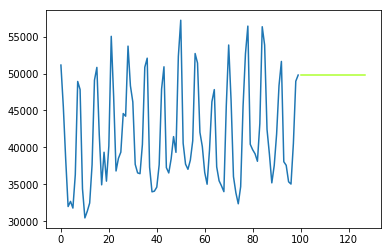

In [47]:
# 朴素预测
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-1]]*28,color='greenyellow')

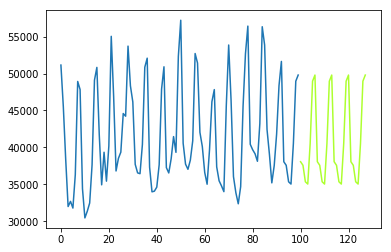

In [54]:
# 季节性朴素预测法
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-i] for i in range(7,0,-1)]*4,color='greenyellow')

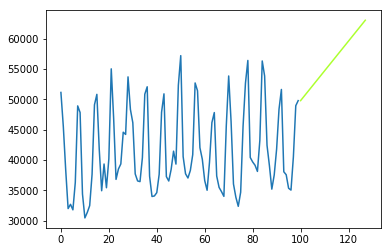

In [56]:
# 飘移动法
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-1]+i*(total_sum[-1]-total_sum[-28])/28 for i in range(28)],color='greenyellow')

In [89]:
# 移动平均
total_ts = pd.Series(total_sum)
moving_mean = total_ts.rolling(window=5).mean()
for i in range(10):
    moving_mean = moving_mean.rolling(window=5).mean()

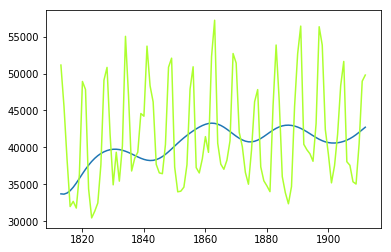

In [90]:
# 画趋势图
plt.plot(moving_mean[-100:])
plt.plot(total_ts[-100:],color='greenyellow')

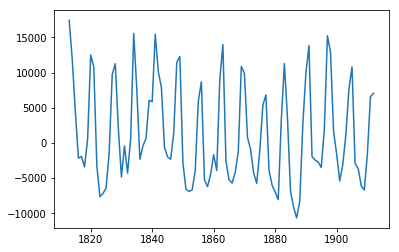

In [100]:
# 减去趋势项，看周期项
plt.plot(total_ts[-100:] - moving_mean)

In [109]:
# STL时序分解算法
import statsmodels.api as sm
rd = sm.tsa.seasonal_decompose(total_sum[-300:], freq=7)

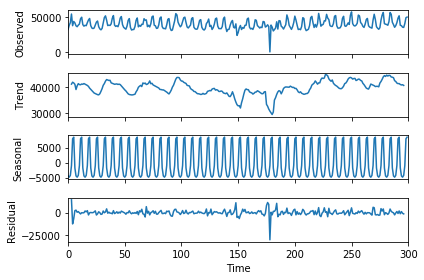

In [110]:
rd.plot();

In [141]:
# 计算趋势性强度
FT = max(0,1-np.std(rd.resid[~np.isnan(rd.resid)])/np.std(tmp[~np.isnan(tmp)]))
print(FT)

0.2591367708554607


In [177]:
# 一阶指数平滑模型
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
alpha = 0.15
simpleExpSmooth_model = SimpleExpSmoothing(total_sum[-10:]).fit(smoothing_level=alpha,optimized=False)

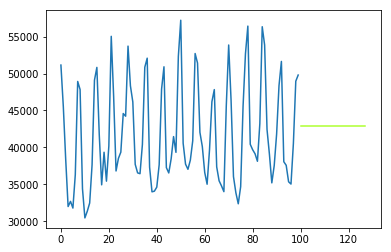

In [178]:
simpleExpSmooth_model.forecast(28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+simpleExpSmooth_model.forecast(28).tolist(),color='greenyellow')

In [194]:
# 二阶指数平滑模型
from statsmodels.tsa.holtwinters import Holt
DaMExpSmooth_model = Holt(total_sum[-120:], damped=True).fit(smoothing_level=0.9, smoothing_slope=0.8)

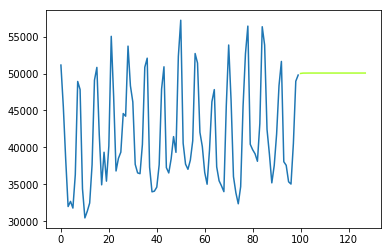

In [195]:
DaMExpSmooth_model.forecast(28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+DaMExpSmooth_model.forecast(28).tolist(),color='greenyellow')

In [204]:
# 三阶指数平滑模型
from statsmodels.tsa.holtwinters import ExponentialSmoothing
HW_ExpSmooth_model = ExponentialSmoothing(total_sum[-120:], seasonal_periods=7, trend='add', seasonal='add', damped=True).fit()

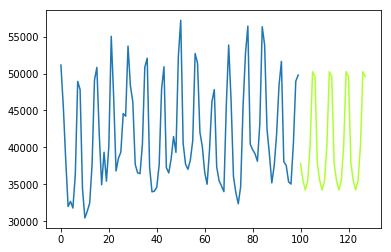

In [205]:
HW_ExpSmooth_model.forecast(28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+HW_ExpSmooth_model.forecast(28).tolist(),color='greenyellow')

In [210]:
# ARIMA 模型
# 使用 auto_arima 包
from pmdarima import auto_arima
arima_model = auto_arima(total_sum[-120:], start_p=0, start_q=0,
                          max_p=10, max_q=5,
                          seasonal=False,
                          d=None, trace=True,random_state=666,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
arima_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2442.797, BIC=2448.355, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=2443.892, BIC=2452.230, Time=0.020 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2443.178, BIC=2451.516, Time=0.025 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=2440.838, BIC=2443.617, Time=0.008 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=2426.588, BIC=2437.704, Time=0.187 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.258 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1209.294
Date:                Fri, 01 May 2020   AIC                           2426.588
Time:                        18:14:21   BIC                           2437.704
Sample:                             0   HQIC                          2431.102
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.4430     24.111      1.304      0.192     -15.814      78.700
ar.L1          0.5907      0.115      5.145      0.000       0.366       0.816
ma.L1         -0.9998      0.169     -5.908      0.000      -1.331      -0.668
sigma2      4.521e+07   4.25e-07   1.06e+14      0.000    4.52e+07    4.52e+07
===================================================================================
Ljung-Box (Q):                      537.91   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.00   Prob(JB):                         0.14
Heteroskedasticity (H):               0.86   Skew:                             0.41
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  3e+31. Standard errors may be unstable.
"""

In [208]:
arima_model.fit(total_sum[-100:])

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

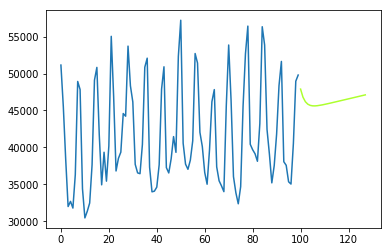

In [211]:
arima_model.predict(n_periods=28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+arima_model.predict(n_periods=28).tolist(),color='greenyellow')

In [213]:
# SARIMA 模型
# 使用 auto_arima 包
from pmdarima import auto_arima
sarima_model = auto_arima(total_sum[-120:], start_p=0, start_q=0,
                          max_p=10, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=666,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 7) (constant=True); AIC=2365.834, BIC=2376.951, Time=0.296 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 7) (constant=True); AIC=2442.797, BIC=2448.355, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 7) (constant=True); AIC=2363.516, BIC=2374.633, Time=0.180 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 7) (constant=True); AIC=2411.174, BIC=2422.291, Time=0.059 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 7) (constant=False); AIC=2440.838, BIC=2443.617, Time=0.010 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 7) (constant=True); AIC=2443.892, BIC=2452.230, Time=0.022 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 0, 7) (constant=True); AIC=2357.022, BIC=2370.917, Time=0.318 seconds
Fit ARIMA: (1, 1, 0)x(2, 0, 1, 7) (constant=True); AIC=2363.010, BIC=2379.685, Time=0.685 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 1, 7) (constant=True); AIC=2364.943, BIC=2378.839, Time=0.372 seconds
Fit ARIMA: (0, 1, 0)x(2, 0, 0, 7) (constant=True); AIC=2356.876, BIC=2367.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(2, 0, 0, 7)   Log Likelihood               -1173.267
Date:                           Fri, 01 May 2020   AIC                           2356.534
Time:                                   18:17:11   BIC                           2370.430
Sample:                                        0   HQIC                          2362.177
                                           - 120                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -75.5506    303.988     -0.249      0.804    -671.357     520.256
ma.L1         -0.1588      0.072     -2.214      0.027      -0.299      -0.018
ar.S.L7        0.4339      0.032     13.764      0.000       0.372       0.496
ar.S.L14       0.2831      0.043      6.621      0.000       0.199       0.367
sigma2      2.041e+07      0.005   3.84e+09      0.000    2.04e+07    2.04e+07
===================================================================================
Ljung-Box (Q):                       69.85   Jarque-Bera (JB):                19.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.17e+25. Standard errors may be unstable.
"""

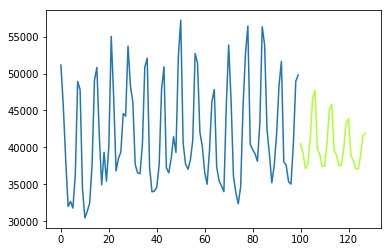

In [214]:
arima_model.predict(n_periods=28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+arima_model.predict(n_periods=28).tolist(),color='greenyellow')